## Book Recommendation Engine Using KNN

I will create a book recommendation algorithm using K-Nearest Neighbors. Since the Nearest Neighbors method uses distance to measure how "close" two instances are to one another, this will be able to display books that are similar to a specific book. So, a function called get_recommends will be used that accepts a book title from the dataset as an argument and outputs a list of 5 books that are relevant to the book argument, along with their distances from it.

The Book Crossings dataset will be utilized. This dataset contains 1.1 million ratings (on a scale of 0-10) of 270,000 books by 90,000 users.

In [ ]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2025-09-30 00:05:12--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  78.8MB/s    in 0.3s    

2025-09-30 00:05:12 (78.8 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [ ]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [ ]:
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [ ]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [ ]:
df_books.isnull().sum()

,0
isbn,0
title,0
author,2


In [ ]:
df_books.dropna(inplace=True)

In [ ]:
df_ratings.isnull().sum()

,0
user,0
isbn,0
rating,0


In [ ]:
df_ratings_user = df_ratings['user'].value_counts()
df_ratings_isbn = df_ratings['isbn'].value_counts()

In [ ]:
df_ratings_user

,count
user,
11676,13602
198711,7550
153662,6109
98391,5891
35859,5850
...,...
119573,1
276706,1
276697,1


In [ ]:
df_ratings_isbn

,count
isbn,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723
...,...
0671883917,1
0743257502,1
0767409752,1


In [ ]:
df_books.shape

(271377, 3)

In [ ]:
df_ratings.shape

(1149780, 3)

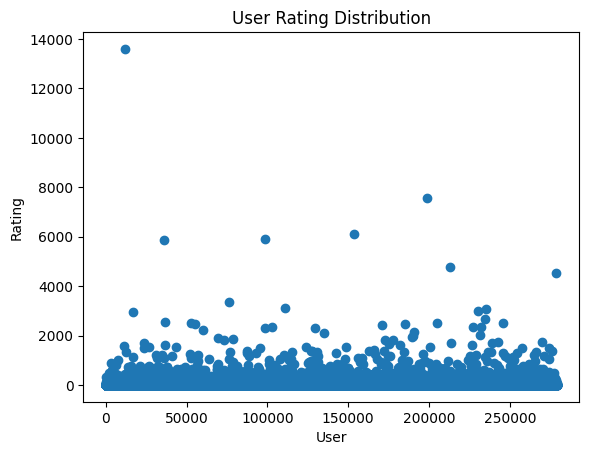

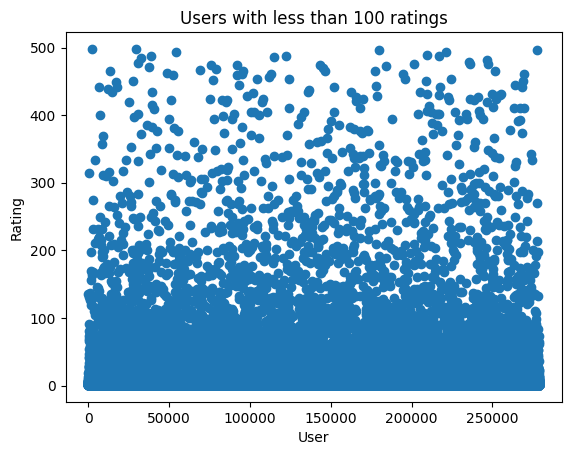

In [ ]:
plt.scatter(df_ratings_user.index, df_ratings_user)
plt.xlabel('User')
plt.ylabel('Rating')
plt.title('User Rating Distribution')
plt.show()

plt.scatter(df_ratings_user[df_ratings_user < 500].index, df_ratings_user[df_ratings_user < 500])
plt.xlabel('User')
plt.ylabel('Rating')
plt.title('Users with less than 100 ratings')
plt.show()

Remove users with less than 200 ratings and books with less than 100 ratings from df_ratings

In [ ]:
users_to_keep = df_ratings_user[df_ratings_user >= 200].index
df_ratings_filtered = df_ratings[df_ratings['user'].isin(users_to_keep)]
df_ratings_filtered.shape

(527556, 3)

In [ ]:
books_to_keep = df_ratings_isbn[df_ratings_isbn >= 100].index
df_ratings_filtered = df_ratings_filtered[df_ratings_filtered['isbn'].isin(books_to_keep)]
df_ratings_filtered.shape

(49781, 3)

In [ ]:
df_ratings_filtered.head()

,user,isbn,rating
1456,277427,002542730X,10.0
1469,277427,0060930535,0.0
1471,277427,0060934417,0.0
1474,277427,0061009059,9.0
1484,277427,0140067477,0.0


In [ ]:
df_ratings_clean = df_ratings_filtered.merge(df_books, on='isbn', how='inner')
df_ratings_clean

,user,isbn,rating,title,author
0,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
1,277427,0060930535,0.0,The Poisonwood Bible: A Novel,Barbara Kingsolver
2,277427,0060934417,0.0,Bel Canto: A Novel,Ann Patchett
3,277427,0061009059,9.0,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich
4,277427,0140067477,0.0,The Tao of Pooh,Benjamin Hoff
...,...,...,...,...,...
49512,275970,0804111359,0.0,Secret History,DONNA TARTT
49513,275970,140003065X,0.0,A Fine Balance,Rohinton Mistry
49514,275970,1400031346,0.0,The No. 1 Ladies' Detective Agency,Alexander McCall Smith
49515,275970,1400031354,0.0,Tears of the Giraffe (No.1 Ladies Detective Ag...,Alexander McCall Smith


In [ ]:
df = df_ratings_clean.pivot_table(index='title', columns='user', values='rating')
df.fillna(0, inplace=True)
df.head()

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.index

Index(['1984', '1st to Die: A Novel', '2nd Chance', '4 Blondes',
       'A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash',
       'A Bend in the Road', 'A Case of Need',
       'A Child Called \It\": One Child's Courage to Survive"',
       'A Civil Action', 'A Confederacy of Dunces (Evergreen Book)',
       ...
       'Wicked: The Life and Times of the Wicked Witch of the West', 'Wifey',
       'Wild Animus', 'Winter Moon', 'Wish You Well', 'Without Remorse',
       'Year of Wonders', 'You Belong To Me',
       'Zen and the Art of Motorcycle Maintenance: An Inquiry into Values',
       '\O\" Is for Outlaw"'],
      dtype='object', name='title', length=673)

Build the Model

In [ ]:
model = NearestNeighbors(metric='cosine')
model.fit(df)

NearestNeighbors(metric='cosine')

In [ ]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  try:
    book = df.loc[book]
  except KeyError as e:
    return f'The book {e} does not exist'

  distance, indice = model.kneighbors([book.values], n_neighbors=6)

  recommended_books = pd.DataFrame({
      'title'   : df.iloc[indice[0]].index.values,
      'distance': distance[0]
    }) \
    .sort_values(by='distance', ascending=False) \
    .head(5).values

  return [book, recommended_books]

In [ ]:
get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")

[user
 254       0.0
 2276      0.0
 2766      0.0
 2977      0.0
 3363      0.0
          ... 
 275970    0.0
 277427    0.0
 277478    0.0
 277639    0.0
 278418    0.0
 Name: The Queen of the Damned (Vampire Chronicles (Paperback)), Length: 888, dtype: float32,
 array([['Catch 22', 0.793983519077301],
        ['The Witching Hour (Lives of the Mayfair Witches)',
         0.7448656558990479],
        ['Interview with the Vampire', 0.7345068454742432],
        ['The Tale of the Body Thief (Vampire Chronicles (Paperback))',
         0.5376338362693787],
        ['The Vampire Lestat (Vampire Chronicles, Book II)',
         0.5178411602973938]], dtype=object)]

Test the Model

In [ ]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0].name != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False

  # Updated recommended books and distances based on the output
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True', 'The Lovely Bones: A Novel']
  recommended_books_dist = [0.8016, 0.7709, 0.7699, 0.7677, 0.7235]

  # Check all 5 recommended books and their distances
  for i in range(5):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False

  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

[user
254        0.0
2276       0.0
2766       0.0
2977       0.0
3363      10.0
          ... 
275970     0.0
277427     0.0
277478     0.0
277639     0.0
278418     0.0
Name: Where the Heart Is (Oprah's Book Club (Paperback)), Length: 888, dtype: float32, array([["I'll Be Seeing You", 0.8016210794448853],
       ['The Weight of Water', 0.7708583474159241],
       ['The Surgeon', 0.7699410915374756],
       ['I Know This Much Is True', 0.7677075266838074],
       ['The Lovely Bones: A Novel', 0.7234864234924316]], dtype=object)]
You passed the challenge! 🎉🎉🎉🎉🎉
